# Conditional sampling evaluation

In [ ]:
# Imports

import os
import torch

from jointformer.configs.dataset import DatasetConfig
from jointformer.utils.datasets.auto import AutoDataset

from jointformer.utils.runtime import set_seed

from jointformer.utils.properties.smiles.qed import QED
from jointformer.utils.properties.smiles.logp import LogP
from jointformer.utils.properties.smiles.sa import SA

import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fine-tune

In [12]:
# Set logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# set seed
SEED = 1337

set_seed(SEED)

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [61]:
# Configs

TARGET_NAME = 'sa'
TARGET_VALUE = 0.7

DATA_DIR = '/lustre/groups/aih/jointformer/icml25/data'
PATH_TO_DATASET_CONFIG   = f'configs/datasets/guacamol_{TARGET_NAME}/config.json'

PATH_TO_GENERATED_SAMPLES = f'/lustre/groups/aih/jointformer/results_icml25_rebuttal/conditional_sampling_corrected/{TARGET_NAME}/llama_backbone/max_epochs_10/decay_lr_true/batch_size_256/learning_rate_5e-4/weight_decay_1e-1/pooler_dropout_0.0/seed_0/generated_samples_{TARGET_NAME}.csv'

# check if paths exist
assert os.path.exists(PATH_TO_GENERATED_SAMPLES), f'Path to model checkpoint does not exist: {PATH_TO_GENERATED_SAMPLES}'


In [62]:
# Load dataset

dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')


Converting target to float32.


In [63]:
# Load samples

_df = pd.read_csv(PATH_TO_GENERATED_SAMPLES)

In [64]:
_df

,idx,smiles,properties,oracle_values,is_valid_smiles
0,0,COc1cc(OC)cc(-c2cc3nc(C)cc(-c4ccccc4)n3n2)c1,0.875137,0.87,True
1,0,CC1CN(c2ncc(C(=O)NCCCCCCC(=O)NO)cc2C(F)(F)F)CCN1,-0.282562,0.76,True
2,0,OC(=Nc1ccc(C(F)(F)F)nc1)c1ccc(-c2nc(C3CCC5C(CC...,-2.456270,NaN,False
3,0,CCCCn1c(=O)c2nc(-c3ccc(Br)cc3)[nH]c2n(CCCC)c1=O,0.428467,0.83,True
4,0,COc1ccc(-c2nnn(Cc3nc(Cc4ccccc4)c4ccccn34)c2-c2...,0.397873,0.82,True
...,...,...,...,...,...
61435,29,Cc1ccccc1NS(=O)(=O)c1csc(C(N)Cn2ccc(=O)[nH]c2=...,-0.357309,0.75,True
61436,29,CCCCCCCCCC(=O)OC1=C(CC=C(C)C)C(=O)c2ccccc2C1=O,0.396136,0.82,True
61437,29,OCC(O)Cn1cnc2nc(OCc3nccs3)nc(O)c21,-0.805798,0.71,True
61438,29,O=C(O)c1ccc(Cl)c(S(=O)(=O)NCCOc2ccccc2)c1,1.214691,0.91,True


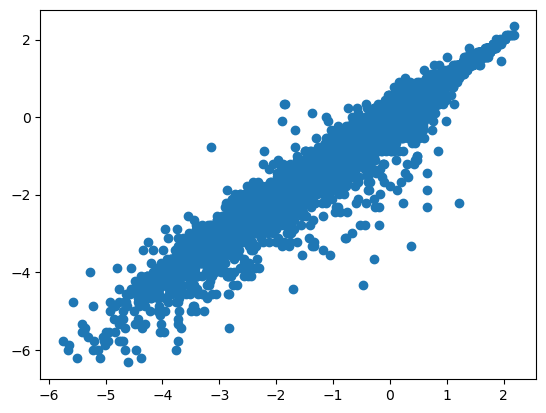

In [65]:
# scatterplot

import matplotlib.pyplot as plt

plt.scatter(_df['properties'], train_dataset.target_transform(_df['oracle_values']))

In [73]:
### best-of-K sampling (if you best of K is simply choosing _epsilon such that at least one sample is selected at every iteration)

samples = []
oracle_values = []
is_valid_sample = []

for idx in _df['idx'].unique():
    # get samples
    _samples = _df[_df['idx'] == idx]['smiles'].tolist()
    # get scores
    _oracle_values = _df[_df['idx'] == idx]['oracle_values'].tolist()
    # get idx
    _properties = _df[_df['idx'] == idx]['properties'].tolist() 
    # get is_valid_sample
    _is_valid_sample = _df[_df['idx'] == idx]['is_valid_smiles'].tolist()

    # get scores
    _scores = np.abs(np.array(_properties) - train_dataset.target_transform(TARGET_VALUE))
    _best_idx = np.argmin(_scores)

    samples.append(_samples[_best_idx])
    oracle_values.append(_oracle_values[_best_idx])
    is_valid_sample.append(_is_valid_sample[_best_idx])

oracle_values = np.array(oracle_values)


In [76]:
# Filter out NaNs
oracle_values = oracle_values[~np.isnan(oracle_values)]

# Sampled
print(f'Sampled {len(samples)} samples')

# Calculate metrics
print('---*---')
mad = np.mean(np.abs(oracle_values - TARGET_VALUE))
print(f'MAD (oracle space): {mad:.3f}')
std = np.std(oracle_values)
print(f'STD (oracle space): {std:.3f}')
print('---*---')
mad = np.mean(np.abs(train_dataset.target_transform(oracle_values) - train_dataset.target_transform(TARGET_VALUE)))
print(f'MAD (normalized space): {mad:.3f}')
std = np.std(train_dataset.target_transform(oracle_values))
print(f'STD (normalized space): {std:.3f}')
print('---*---')
validity = len(is_valid_sample) / len(is_valid_sample)
print(f'Validity: {validity:.3f}')


Sampled 30 samples
---*---
MAD (oracle space): 0.008
STD (oracle space): 0.012
---*---
MAD (normalized space): 0.092
STD (normalized space): 0.138
---*---
Validity: 1.000


In [79]:
### Joint sampling 

_epsilon = 0.001

_scores = np.abs(np.array(_df['properties']) - train_dataset.target_transform(TARGET_VALUE))
samples = _df.loc[_scores < _epsilon, 'smiles'].tolist()
oracle_values = _df.loc[_scores < _epsilon, 'oracle_values']
is_valid_sample = _df.loc[_scores < _epsilon, 'is_valid_smiles']

In [80]:
# Filter out NaNs
oracle_values = oracle_values[~oracle_values.isna()]

# Sampled
print(f'Sampled {len(samples)} samples')

# Calculate metrics
print('---*---')
mad = np.mean(np.abs(oracle_values - TARGET_VALUE))
print(f'MAD (oracle space): {mad:.3f}')
std = np.std(oracle_values)
print(f'STD (oracle space): {std:.3f}')
print('---*---')
mad = np.mean(np.abs(train_dataset.target_transform(oracle_values) - train_dataset.target_transform(TARGET_VALUE)))
print(f'MAD (normalized space): {mad:.3f}')
std = np.std(train_dataset.target_transform(oracle_values))
print(f'STD (normalized space): {std:.3f}')
print('---*---')
validity = len(is_valid_sample) / len(is_valid_sample)
print(f'Validity: {validity:.3f}')


Sampled 18 samples
---*---
MAD (oracle space): 0.006
STD (oracle space): 0.009
---*---
MAD (normalized space): 0.068
STD (normalized space): 0.100
---*---
Validity: 1.000
